In [ ]:
# %load PCsampling_demo_tc1202.py
#@title Autoload all modules


from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import io
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import importlib
import os
import functools
import itertools
import torch
from losses import get_optimizer
from models.ema import ExponentialMovingAverage

import torch.nn as nn
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_gan as tfgan
import tqdm
import io
import likelihood
import controllable_generation
from utils import restore_checkpoint
sns.set(font_scale=2)
sns.set(style="whitegrid")

import models
from models import utils as mutils
from models import ncsnv2
from models import ncsnpp
from models import ddpm as ddpm_model
from models import layerspp
from models import layers
from models import normalization
import sampling_ktxt_sake_tc1202
from likelihood import get_likelihood_fn
from sde_lib import VESDE, VPSDE, subVPSDE
from sampling_ktxt_sake_tc1202 import (ReverseDiffusionPredictor,
                      LangevinCorrector, 
                      EulerMaruyamaPredictor, 
                      AncestralSamplingPredictor, 
                      NoneCorrector, 
                      NonePredictor,
                      AnnealedLangevinDynamics)
import datasets
import os.path as osp

import argparse
parser = argparse.ArgumentParser(description="some settings")
parser.add_argument("--datanum", type=int, default=1, help="the number of the test data")
args = parser.parse_args()
print("Parsed arguments: {}".format(args))

# @title Load the score-based model
sde = 'VESDE' #@param ['VESDE', 'VPSDE', 'subVPSDE'] {"type": "string"}
if sde.lower() == 'vesde':
    from configs.ve import SIAT_kdata_ncsnpp_test as configs  # 修改config
    model_num = 'checkpoint.pth'
    ckpt_filename_kt = './exp_kt/exp_kt_380_0.01/checkpoint_14.pth'
    ckpt_filename_xt = './exp_xt/exp_xt_378_0.01/checkpoint_20.pth'
    ########################################################################
    config = configs.get_config()
    sde = VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales) #  sde
    #sde = VESDE(sigma_min=0.01, sigma_max=10, N=100) #  sde
    sampling_eps = 1e-5

########################################################################
batch_size = 16 #@param {"type":"integer"}
########################################################################
config.training.batch_size = batch_size
config.eval.batch_size = batch_size

random_seed = 0 #@param {"type": "integer"}

sigmas = mutils.get_sigmas(config)
scaler = datasets.get_data_scaler(config)
inverse_scaler = datasets.get_data_inverse_scaler(config)
#load kt model
score_model_kt = mutils.create_model(config)

optimizer = get_optimizer(config, score_model_kt.parameters())
ema = ExponentialMovingAverage(score_model_kt.parameters(),
                               decay=config.model.ema_rate)
state = dict(step=0, optimizer=optimizer,
             model=score_model_kt, ema=ema)


state = restore_checkpoint(ckpt_filename_kt, state, config.device)
ema.copy_to(score_model_kt.parameters())

#load xt model
score_model_xt = mutils.create_model(config)

optimizer = get_optimizer(config, score_model_xt.parameters())
ema = ExponentialMovingAverage(score_model_xt.parameters(),
                            decay=config.model.ema_rate)
state = dict(step=0, optimizer=optimizer,
          model=score_model_xt, ema=ema)

state = restore_checkpoint(ckpt_filename_xt, state, config.device)
ema.copy_to(score_model_xt.parameters())

#@title PC sampling
img_size = config.data.image_size
channels = config.data.num_channels
shape = (batch_size, channels, img_size, img_size)
predictor = ReverseDiffusionPredictor #@param ["EulerMaruyamaPredictor", "AncestralSamplingPredictor", "ReverseDiffusionPredictor", "None"] {"type": "raw"}
corrector = LangevinCorrector #@param ["LangevinCorrector", "AnnealedLangevinDynamics", "None"] {"type": "raw"}
snr = 0.075 #0.16 #@param {"type": "number"}
n_steps = 1 #@param {"type": "integer"}
probability_flow = False #@param {"type": "boolean"}
########################################################################
sampling_fn = sampling_ktxt_sake_tc1202.get_pc_sampler(sde, shape, predictor, corrector,
                                      inverse_scaler, snr, n_steps=n_steps,
                                      probability_flow=probability_flow,
                                      continuous=config.training.continuous,
                                      eps=sampling_eps, device=config.device, data_num=args.datanum)

x, n = sampling_fn(score_model_kt, score_model_xt)



In [ ]:
# %load sampling_ktxt_sake_tc1202.py
# Copyright 2020 The Google Research Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# pylint: skip-file
# pytype: skip-file
"""Various sampling methods."""
import functools

import torch
import numpy as np
import abc

from models.utils import from_flattened_numpy, to_flattened_numpy, get_score_fn
from scipy import integrate
import sde_lib
from models import utils as mutils
#from skimage.measure import compare_psnr,compare_ssim
from skimage.metrics import structural_similarity as SSIM
from skimage.metrics import peak_signal_noise_ratio as PSNR
import cv2
import os.path as osp
import matplotlib.pyplot as plt
from scipy.io import loadmat 
from SAKE import fft2c, ifft2c, im2row, row2im, sake
import scipy.io as io
from logging_l import make_print_to_file
from scipy.io import savemat
import os

import time

def compare_hfen(rec,ori):
    operation = np.array(io.loadmat("./mask/loglvbo.mat")['h1'],dtype=np.float32)
    ori = cv2.filter2D(ori.astype('float32'), -1, operation,borderType=cv2.BORDER_CONSTANT)
    rec = cv2.filter2D(rec.astype('float32'), -1, operation,borderType=cv2.BORDER_CONSTANT)
    hfen = np.linalg.norm(ori-rec, ord = 'fro')
    return hfen

def write_kdata(Kdata,name):
    temp = np.log(1+abs(Kdata))    
    plt.axis('off')
    plt.imshow(abs(temp),cmap='gray')
    plt.savefig(osp.join('./result/',name),transparent=True, dpi=128, pad_inches = 0,bbox_inches = 'tight')

def write_Data(model_num,psnr,ssim):
    filedir="result.txt"
    with open(osp.join('./result/',filedir),"a+") as f:#a+
        f.writelines(str(model_num)+' '+'['+str(round(psnr, 4))+' '+str(round(ssim, 4))+']')
        f.write('\n')


def write_Datax(filedir, dataname, model_num, radio, psnr, ssim, hfen):
  # filedir = "result.txt"
  if not os.path.exists(filedir):
    os.mkdir(filedir)
  with open(osp.join(filedir, dataname), "a+") as f:  # a+
    f.writelines(str(model_num) + ': ' + str(round(radio, 2)) + ',  ' + '[' + str(round(psnr, 4)) + ',  ' + str(round(ssim, 4)) + ',  ' +  str(round(hfen, 4)) + ']')
    f.write('\n')

def write_Data_mx(filedir, dataname, index, model_num, radio, psnr, ssim, hfen):
  # filedir = "result.txt"
  if not os.path.exists(filedir):
    os.mkdir(filedir)
  with open(osp.join(filedir, dataname), "w+") as f:  # a+
    f.writelines(str(model_num) + '  (' + str(index) + ' ) :  ' + str(round(radio, 2)) + ',  ' + '[' + str(round(psnr, 4)) + ',  ' + str(round(ssim, 4)) + ',  ' +  str(round(hfen, 4)) + ']')
    f.write('\n')

def write_Data_mid(filedir, dataname, model_num, radio, num, psnr, ssim, hfen):
  # filedir = "result_mid.txt"
  if not os.path.exists(filedir):
    os.mkdir(filedir)
  with open(osp.join(filedir, dataname), "a+") as f:  # a+
    f.writelines(str(model_num) + ': ' + 'radio=' +str(round(radio, 2)) + ',  ' +str(num) + ' :' + '[' + str(round(psnr, 4)) + ',  ' + str(round(ssim, 4)) + ',  ' + str(round(hfen, 4)) + ']')
    f.write('\n')

def write_images(x,image_save_path):
    x = np.clip(x * 255, 0, 255).astype(np.uint8)
    cv2.imwrite(image_save_path, x)

def save_data(save_filepath, dataname, data_key, save_data):
  if not os.path.exists(save_filepath):
    os.mkdir(save_filepath)
  savemat(osp.join(save_filepath,dataname), {data_key: save_data})


def k2wgt(X,W):
    Y = np.multiply(X,W) 
    return Y

def wgt2k(X,W,DC):
    Y = np.multiply(X,1./W)
    Y[W==0] = DC[W==0] 
    return Y

_CORRECTORS = {}
_PREDICTORS = {}


def register_predictor(cls=None, *, name=None):
  def _register(cls):
    if name is None:
      local_name = cls.__name__
    else:
      local_name = name
    if local_name in _PREDICTORS:
      raise ValueError(f'Already registered model with name: {local_name}')
    _PREDICTORS[local_name] = cls
    return cls

  if cls is None:
    return _register
  else:
    return _register(cls)


def register_corrector(cls=None, *, name=None):
  """A decorator for registering corrector classes."""

  def _register(cls):
    if name is None:
      local_name = cls.__name__
    else:
      local_name = name
    if local_name in _CORRECTORS:
      raise ValueError(f'Already registered model with name: {local_name}')
    _CORRECTORS[local_name] = cls
    return cls

  if cls is None:
    return _register
  else:
    return _register(cls)


def get_predictor(name):
  return _PREDICTORS[name]


def get_corrector(name):
  return _CORRECTORS[name]


def get_sampling_fn(config, sde, shape, inverse_scaler, eps):
  sampler_name = config.sampling.method
  # Probability flow ODE sampling with black-box ODE solvers
  if sampler_name.lower() == 'ode':
    sampling_fn = get_ode_sampler(sde=sde,
                                  shape=shape,
                                  inverse_scaler=inverse_scaler,
                                  denoise=config.sampling.noise_removal,
                                  eps=eps,
                                  device=config.device)
  # Predictor-Corrector sampling. Predictor-only and Corrector-only samplers are special cases.
  elif sampler_name.lower() == 'pc':
    predictor = get_predictor(config.sampling.predictor.lower())
    corrector = get_corrector(config.sampling.corrector.lower())
    sampling_fn = get_pc_sampler(sde=sde,
                                 shape=shape,
                                 predictor=predictor,
                                 corrector=corrector,
                                 inverse_scaler=inverse_scaler,
                                 snr=config.sampling.snr,
                                 n_steps=config.sampling.n_steps_each,
                                 probability_flow=config.sampling.probability_flow,
                                 continuous=config.training.continuous,
                                 denoise=config.sampling.noise_removal,
                                 eps=eps,
                                 device=config.device)
  else:
    raise ValueError(f"Sampler name {sampler_name} unknown.")

  return sampling_fn


class Predictor(abc.ABC):
  """The abstract class for a predictor algorithm."""

  def __init__(self, sde, score_fn, probability_flow=False):
    super().__init__()
    self.sde = sde
    # Compute the reverse SDE/ODE
    self.rsde = sde.reverse(score_fn, probability_flow)
    self.score_fn = score_fn

  @abc.abstractmethod
  def update_fn(self, x, t):
    pass


class Corrector(abc.ABC):
  """The abstract class for a corrector algorithm."""

  def __init__(self, sde, score_fn, snr, n_steps):
    super().__init__()
    self.sde = sde
    self.score_fn = score_fn
    self.snr = snr
    self.n_steps = n_steps

  @abc.abstractmethod
  def update_fn(self, x, t):
    pass


@register_predictor(name='euler_maruyama')
class EulerMaruyamaPredictor(Predictor):
  def __init__(self, sde, score_fn, probability_flow=False):
    super().__init__(sde, score_fn, probability_flow)

  def update_fn(self, x, t):
    dt = -1. / self.rsde.N
    z = torch.randn_like(x)
    drift, diffusion = self.rsde.sde(x, t)
    x_mean = x + drift * dt
    x = x_mean + diffusion[:, None, None, None] * np.sqrt(-dt) * z
    return x, x_mean


@register_predictor(name='reverse_diffusion')
class ReverseDiffusionPredictor(Predictor):
  def __init__(self, sde, score_fn, probability_flow=False):
    super().__init__(sde, score_fn, probability_flow)
  
  # Alogrithm 2
  def update_fn(self, x, t):
    f, G = self.rsde.discretize(x, t) # 3
    z = torch.randn_like(x) # 4
    x_mean = x - f # 3
    x = x_mean + G[:, None, None, None] * z # 5  
    
    return x, x_mean


@register_predictor(name='ancestral_sampling')
class AncestralSamplingPredictor(Predictor):
  """The ancestral sampling predictor. Currently only supports VE/VP SDEs."""

  def __init__(self, sde, score_fn, probability_flow=False):
    super().__init__(sde, score_fn, probability_flow)
    if not isinstance(sde, sde_lib.VPSDE) and not isinstance(sde, sde_lib.VESDE):
      raise NotImplementedError(f"SDE class {sde.__class__.__name__} not yet supported.")
    assert not probability_flow, "Probability flow not supported by ancestral sampling"

  def vesde_update_fn(self, x, t):
    sde = self.sde
    timestep = (t * (sde.N - 1) / sde.T).long()
    sigma = sde.discrete_sigmas[timestep]
    adjacent_sigma = torch.where(timestep == 0, torch.zeros_like(t), sde.discrete_sigmas.to(t.device)[timestep - 1])
    score = self.score_fn(x, t)
    x_mean = x + score * (sigma ** 2 - adjacent_sigma ** 2)[:, None, None, None]
    std = torch.sqrt((adjacent_sigma ** 2 * (sigma ** 2 - adjacent_sigma ** 2)) / (sigma ** 2))
    noise = torch.randn_like(x)
    x = x_mean + std[:, None, None, None] * noise
    return x, x_mean

  def vpsde_update_fn(self, x, t):
    sde = self.sde
    timestep = (t * (sde.N - 1) / sde.T).long()
    beta = sde.discrete_betas.to(t.device)[timestep]
    score = self.score_fn(x, t)
    x_mean = (x + beta[:, None, None, None] * score) / torch.sqrt(1. - beta)[:, None, None, None]
    noise = torch.randn_like(x)
    x = x_mean + torch.sqrt(beta)[:, None, None, None] * noise
    return x, x_mean

  def update_fn(self, x, t):
    if isinstance(self.sde, sde_lib.VESDE):
      return self.vesde_update_fn(x, t)
    elif isinstance(self.sde, sde_lib.VPSDE):
      return self.vpsde_update_fn(x, t)


@register_predictor(name='none')
class NonePredictor(Predictor):
  """An empty predictor that does nothing."""

  def __init__(self, sde, score_fn, probability_flow=False):
    pass

  def update_fn(self, x, t):
    return x, x


@register_corrector(name='langevin')
class LangevinCorrector(Corrector):
  def __init__(self, sde, score_fn, snr, n_steps):
    super().__init__(sde, score_fn, snr, n_steps)
    if not isinstance(sde, sde_lib.VPSDE) \
        and not isinstance(sde, sde_lib.VESDE) \
        and not isinstance(sde, sde_lib.subVPSDE):
      raise NotImplementedError(f"SDE class {sde.__class__.__name__} not yet supported.")

  def update_fn(self, x1,x2,x3,x_mean,t):
    sde = self.sde
    score_fn = self.score_fn
    n_steps = self.n_steps
    target_snr = self.snr
    if isinstance(sde, sde_lib.VPSDE) or isinstance(sde, sde_lib.subVPSDE):
      timestep = (t * (sde.N - 1) / sde.T).long()
      alpha = sde.alphas.to(t.device)[timestep]
    else:
      alpha = torch.ones_like(t)
    
    # Algorithm 4
    for i in range(n_steps):
   
      grad1 = score_fn(x1, t) # 5 
      grad2 = score_fn(x2, t) # 5 
      grad3 = score_fn(x3, t) # 5 
      
      noise1 = torch.randn_like(x1) # 4 
      noise2 = torch.randn_like(x2) # 4
      noise3 = torch.randn_like(x3) # 4

      
      grad_norm1 = torch.norm(grad1.reshape(grad1.shape[0], -1), dim=-1).mean()
      noise_norm1 = torch.norm(noise1.reshape(noise1.shape[0], -1), dim=-1).mean()
      grad_norm2 = torch.norm(grad2.reshape(grad2.shape[0], -1), dim=-1).mean()
      noise_norm2 = torch.norm(noise2.reshape(noise2.shape[0], -1), dim=-1).mean()      
      grad_norm3 = torch.norm(grad3.reshape(grad3.shape[0], -1), dim=-1).mean()
      noise_norm3 = torch.norm(noise3.reshape(noise3.shape[0], -1), dim=-1).mean()            
      
      grad_norm =(grad_norm1+grad_norm2+grad_norm3)/3.0
      noise_norm = (noise_norm1+noise_norm2+noise_norm3)/3.0
      
      step_size =  (2 * alpha)*((target_snr * noise_norm / grad_norm) ** 2 ) # 6 
   
      x_mean = x_mean + step_size[:, None, None, None] * (grad1+grad2+grad3)/3.0 # 7
      
      x1 = x_mean + torch.sqrt(step_size * 2)[:, None, None, None] * noise1 # 7
      x2 = x_mean + torch.sqrt(step_size * 2)[:, None, None, None] * noise2 # 7
      x3 = x_mean + torch.sqrt(step_size * 2)[:, None, None, None] * noise3 # 7
      
    return x1,x2,x3,x_mean


@register_corrector(name='ald')
class AnnealedLangevinDynamics(Corrector):
  def __init__(self, sde, score_fn, snr, n_steps):
    super().__init__(sde, score_fn, snr, n_steps)
    if not isinstance(sde, sde_lib.VPSDE) \
        and not isinstance(sde, sde_lib.VESDE) \
        and not isinstance(sde, sde_lib.subVPSDE):
      raise NotImplementedError(f"SDE class {sde.__class__.__name__} not yet supported.")

  def update_fn(self, x, t):
    sde = self.sde
    score_fn = self.score_fn
    n_steps = self.n_steps
    target_snr = self.snr
    if isinstance(sde, sde_lib.VPSDE) or isinstance(sde, sde_lib.subVPSDE):
      timestep = (t * (sde.N - 1) / sde.T).long()
      alpha = sde.alphas.to(t.device)[timestep]
    else:
      alpha = torch.ones_like(t)

    std = self.sde.marginal_prob(x, t)[1]
   
    for i in range(n_steps):
      grad = score_fn(x, t)
      noise = torch.randn_like(x)
      step_size = (target_snr * std) ** 2 * 2 * alpha
      x_mean = x + step_size[:, None, None, None] * grad
      x = x_mean + noise * torch.sqrt(step_size * 2)[:, None, None, None]
    return x, x_mean


@register_corrector(name='none')
class NoneCorrector(Corrector):
  """An empty corrector that does nothing."""

  def __init__(self, sde, score_fn, snr, n_steps):
    pass

  def update_fn(self, x, t):
    return x, x


def shared_predictor_update_fn(x, t, sde, model, predictor, probability_flow, continuous):
  """A wrapper that configures and returns the update function of predictors."""
  score_fn = mutils.get_score_fn(sde, model, train=False, continuous=continuous)
  if predictor is None:
    # Corrector-only sampler
    predictor_obj = NonePredictor(sde, score_fn, probability_flow)
  else:
    predictor_obj = predictor(sde, score_fn, probability_flow)
  return predictor_obj.update_fn(x, t)


def shared_corrector_update_fn(x1,x2,x3,x_mean,t,sde, model, corrector, continuous, snr, n_steps):
  """A wrapper tha configures and returns the update function of correctors."""
  score_fn = mutils.get_score_fn(sde, model, train=False, continuous=continuous)
  if corrector is None:
    # Predictor-only sampler
    corrector_obj = NoneCorrector(sde, score_fn, snr, n_steps)
  else:
    corrector_obj = corrector(sde, score_fn, snr, n_steps)
  return corrector_obj.update_fn(x1,x2,x3,x_mean,t)


def get_pc_sampler(sde, shape, predictor, corrector, inverse_scaler, snr,
                   n_steps=1, probability_flow=False, continuous=False,
                   denoise=True, eps=1e-3, device='cuda', data_num=1):

  # Create predictor & corrector update functions
  predictor_update_fn = functools.partial(shared_predictor_update_fn,
                                          sde=sde,
                                          predictor=predictor,
                                          probability_flow=probability_flow,
                                          continuous=continuous)
  corrector_update_fn = functools.partial(shared_corrector_update_fn,
                                          sde=sde,
                                          corrector=corrector,
                                          continuous=continuous,
                                          snr=snr,
                                          n_steps=n_steps) 

load ori_xt_data


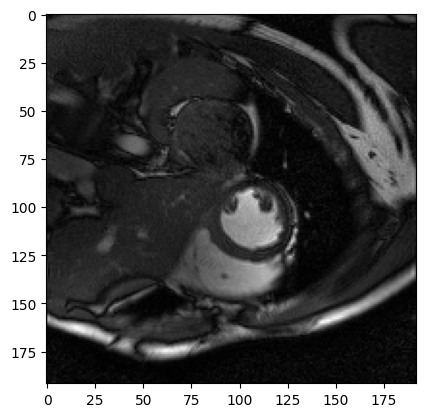

In [21]:
## load ori_xt_data

def pc_sampler(kt_model,xt_model):
    with torch.no_grad():
        file_path_x = './input_data/dataset_test/data_xt_test_gonge/' + str(num) + '.mat'
        xt_data = loadmat(file_path_x)['data_xt']
        xt_data = xt_data.transpose(2, 0, 1)

        xt_data_sos = np.abs(xt_data[0,:,:])
        plt.imshow(xt_data_sos,cmap='gray')
        plt.show() 

load ori_kt_data


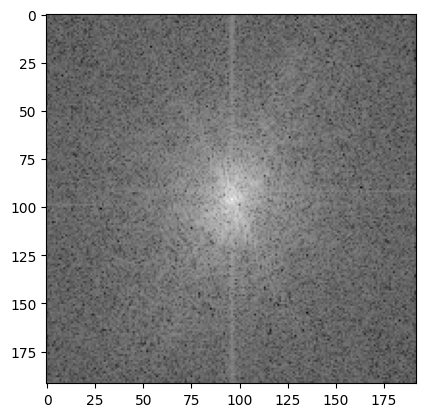

In [28]:
## load ori_xt_data

file_path_k = './input_data/dataset_test/data_kt_test_gonge/' + str(num) + '.mat'
kt_data = loadmat(file_path_k)['data_kt']
kt_data = kt_data.transpose(2, 0, 1)
kt_data_sos = np.abs(kt_data[0,:,:])
plt.imshow(np.log(kt_data_sos),cmap='gray')
plt.show()      

show weight
weight


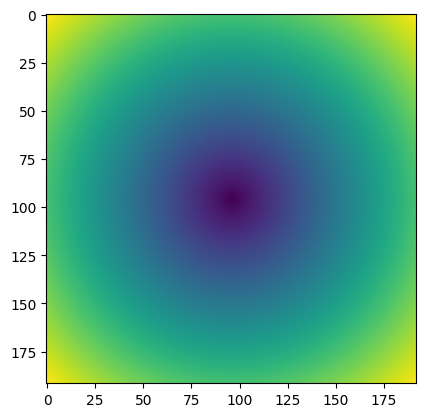

In [10]:
## load weight
# load weight and repeat to t size

weight_path = '../weight/weight1.mat'
weight = loadmat(weight_path)['weight']
weight_t = np.zeros((kt_k, kx_k, ky_k))
for i in range(0, kt_k):
    weight_t[i, :, :] = weight
weight_sos = np.abs(weight)
print("show weight")
print("weight")
plt.imshow(weight_sos)
plt.show()

show mask
Cart_R10


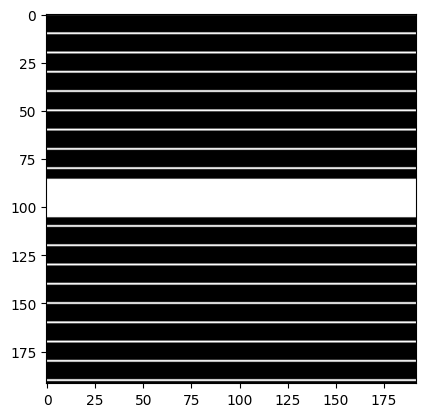

In [5]:
##     load mask

mask_Rn_path = '../mask/mask_Rn/mask_R10.mat'
mask_Rn = loadmat(mask_Rn_path)['mask']

# load mask_acs
mask_acs_path = '../mask/mask_acs/mask_acs20.mat'
mask_acs = loadmat(mask_acs_path)['mask_acs']

# mask_t
mask = mask_Rn | mask_acs

mask_sos = np.abs(mask[:,:,0])
print("show mask")
print("Cart_R10")
plt.imshow(mask_sos,'gray')
plt.show()

show zerosfilled_data


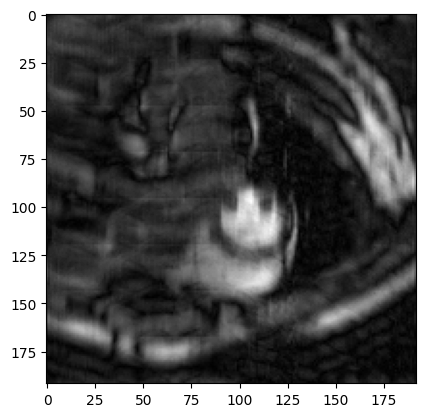

zerosfilled value of the output result
zerosfilled psnr:  21.73
zerosfilled ssim:  0.5591
zerosfilled mse:  53.87 *e-4


In [6]:
##  load zf_data
# data setting（初始化数组）
k_t_data_k = np.zeros((kt_k, kx_k, ky_k), dtype=np.complex64)
x_t_data_k = np.zeros((kt_k, kx_k, ky_k), dtype=np.complex64)
k_t_sampled_data_k = np.zeros((kt_k, kx_k, ky_k), dtype=np.complex64)
x_t_zerofilled_data_k = np.zeros((kt_k, kx_k, ky_k), dtype=np.complex64)
k_t_w_sampled_data = np.zeros((kt_k, kx_k, ky_k), dtype=np.complex64)

k_t_data_k = ori_data_k
for i in range(kt_k):
    x_t_data_k[i, :, :] = np.fft.ifft2(k_t_data_k[i, :, :])
    #把图像变成欠采图
    k_t_sampled_data_k[i, :, :] = np.multiply(mask[i, :, :], k_t_data_k[i, :, :])
    x_t_zerofilled_data_k[i, :, :] = np.fft.ifft2(k_t_sampled_data_k[i, :, :])
    k_t_w_sampled_data[i, :, :] = k2wgt(k_t_sampled_data_k[i, :, :], weight_t[i, :, :])

x_t_data_transpose = x_t_data_k.transpose(1, 2, 0)    # 192*192*16
x_input_k = np.random.uniform(-1,1,size=(kt_k, 2, kx_k, ky_k))

x_input_k[:,0,:,:] = np.real(k_t_sampled_data_k);
x_input_k[:,1,:,:] = np.imag(k_t_sampled_data_k);

x_input_k = torch.from_numpy(x_input_k).to(device) #从numpy中导入tensor
x_mean_k = torch.tensor(x_input_k, dtype=torch.float32).cuda()  #将图像数据转化为张量（2维以上矩阵），并把张量数据转移到GPU中
x1 = x_mean_k
x2 = x_mean_k
x3 = x_mean_k

file_path_x = './input_data/dataset_test/data_xt_test_gonge/' + str(num) + '.mat'
xt_data = loadmat(file_path_x)['data_xt']
xt_data = xt_data.transpose(2, 0, 1)
ori_data_x = np.zeros((16, 192, 192), dtype=np.complex64)
for i in range(16):
    ori_data_x[i, :, :] = np.fft.fftshift(np.fft.fft2(xt_data[i, :, :]))  # need fftshift???

[kt_x, kx_x, ky_x] = ori_data_x.shape
ori_img_x = np.zeros((kt_x, kx_x, ky_x), dtype=np.complex64)
for i in range(kt_x):
    ori_img_x[i, :, :] = np.fft.ifft2(ori_data_x[i, :, :])

k_t_data_x = np.zeros((kt_x, kx_x, ky_x), dtype=np.complex64)
x_t_data_x = np.zeros((kt_x, kx_x, ky_x), dtype=np.complex64)
k_t_sampled_data_x = np.zeros((kt_x, kx_x, ky_x), dtype=np.complex64)
x_t_zerofilled_data_x = np.zeros((kt_x, kx_x, ky_x), dtype=np.complex64)

k_t_data_x = ori_data_x
for i in range(kt_x):
    x_t_data_x[i, :, :] = np.fft.ifft2(k_t_data_x[i, :, :])
    k_t_sampled_data_x[i, :, :] = np.multiply(mask[i, :, :], k_t_data_x[i, :, :])
    x_t_zerofilled_data_x[i, :, :] = np.fft.ifft2(k_t_sampled_data_x[i, :, :])

x_input_x = np.random.uniform(-1, 1, size=(kt_x, 2, kx_x, ky_x))
x_input_x[:, 0, :, :] = np.real(x_t_zerofilled_data_x)
x_input_x[:, 1, :, :] = np.imag(x_t_zerofilled_data_x)
x_input_x = torch.from_numpy(x_input_x).to(device)
x_mean_x = torch.tensor(x_input_x, dtype=torch.float32).cuda()
x4 = x_mean_x
x5 = x_mean_x
x6 = x_mean_x
        
# cycle 初始化衡量指标
psnr_max = 0
ssim_max = 0
hfen_max = 0
k = -1
k_w = np.zeros((kt_k, kx_k, ky_k),dtype=np.complex64)

x_t = np.zeros((kt_x, kx_x, ky_x), dtype=np.complex64)
k_t = np.zeros((kt_x, kx_x, ky_x), dtype=np.complex64)
kt2xt_temp = np.zeros((kt_x, kx_x, ky_x), dtype=np.complex64)

PSNR_zerofilled_all = []
SSIM_zerofilled_all = []
HFEN_zerofilled_all = []

for i in range(16):
    eval_ori = (abs(ori_img_x[i, :, :])) / np.max(abs(ori_img_x[i, :, :]))
    eval_zerofilled = (abs(x_t_zerofilled_data_k[i, :, :])) / np.max(abs(x_t_zerofilled_data_k[i, :, :]))
    psnr_ori_zerofilled = PSNR(255 * eval_ori, 255 * eval_zerofilled, data_range=255)
    ssim_ori_zerofilled = SSIM(eval_ori, eval_zerofilled, data_range=1)
    hfen_ori_zerofilled = compare_hfen(eval_zerofilled, eval_ori)
    PSNR_zerofilled_all.append(psnr_ori_zerofilled)
    SSIM_zerofilled_all.append(ssim_ori_zerofilled)
    HFEN_zerofilled_all.append(hfen_ori_zerofilled)

ave_zerofilled_psnr = sum(PSNR_zerofilled_all) / len(PSNR_zerofilled_all)
ave_zerofilled_ssim = sum(SSIM_zerofilled_all) / len(SSIM_zerofilled_all)
ave_zerofilled_hfen = sum(HFEN_zerofilled_all) / len(HFEN_zerofilled_all)

##  load zf_data
print("show zerosfilled_data")
plt.imshow(ori_data_sos,'gray')
plt.show()

print('zerosfilled value of the output result')
print('zerosfilled psnr: ', psnr_zf)
print('zerosfilled ssim: ', ssim_zf)
print('zerosfilled mse: ', mse_zf,'*e-4')

show rec_data_201


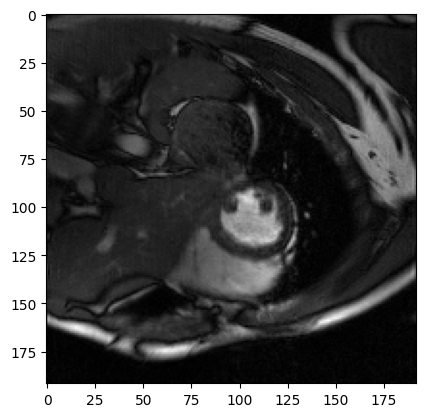

In [18]:
for i in range(sde.N):
    k = k + 1
    print('================= ',i)
    t = timesteps[i]    #时刻t
    #定义一个全为1的kt_k大小的张量，*t则张量全为t
    vec_t = torch.ones(shape[0], device=t.device) * t
    ksize = [6, 6]
    wnthresh = 1.5
    sakeIter = 1

    start_innertime = time.time()
    ##======================================================= Predictor
    x, x_mean_k = predictor_update_fn(x_mean_k, vec_t, model=kt_model)
    x_mean_k = x_mean_k.cpu().numpy()
    x_mean_k = np.array(x_mean_k, dtype=np.float32)

    kw_real = np.zeros((kt_k, kx_k, ky_k), dtype=np.float32)
    kw_imag = np.zeros((kt_k, kx_k, ky_k), dtype=np.float32)
    #经过预测器后实虚部结合
    for i in range(kt_k):
        kw_real[i, :, :] = x_mean_k[i, 0, :, :]
        kw_imag[i, :, :] = x_mean_k[i, 1, :, :]
        k_w[i, :, :] = kw_real[i, :, :] + 1j * kw_imag[i, :, :]

    # data consistency
    w2k_complex = np.zeros((kt_k, kx_k, ky_k), dtype=np.complex64)
    k_dc_complex = np.zeros((kt_k, kx_k, ky_k), dtype=np.complex64)
    for i in range(kt_k):
        w2k_complex[i, :, :] = wgt2k(k_w[i, :, :], weight_t[i, :, :], k_t_sampled_data_k[i, :, :])
        k_dc_complex[i, :, :] = k_t_sampled_data_k[i, :, :] + w2k_complex[i, :, :] * (1 - mask[i, :, :])

    # iteration 1
    x_input_k = np.zeros((kt_k, 2, kx_k, ky_k),dtype=np.float32)
    for i in range(kt_k):
        k_w[i, :, :] = k2wgt(k_dc_complex[i, :, :], weight_t[i, :, :])
        x_input_k[i, 0, :, :] = np.real(k_w[i, :, :])
        x_input_k[i, 1, :, :] = np.imag(k_w[i, :, :])
    x_mean_k = torch.tensor(x_input_k, dtype=torch.float32).cuda()

    ##======================================================= Corrector
    x1, x2, x3, x_mean_k = corrector_update_fn(x1, x2, x3, x_mean_k, vec_t, model=kt_model)
    x_mean_k = x_mean_k.cpu().numpy()
    x_mean_k = np.array(x_mean_k, dtype=np.float32)

    kw_real = np.zeros((kt_k, kx_k, ky_k), dtype=np.float32)
    kw_imag = np.zeros((kt_k, kx_k, ky_k), dtype=np.float32)
    for i in range(kt_k):
        kw_real[i, :, :] = x_mean_k[i, 0, :, :]
        kw_imag[i, :, :] = x_mean_k[i, 1, :, :]
        k_w[i, :, :] = kw_real[i, :, :] + 1j * kw_imag[i, :, :]

    # data consistency
    w2k_complex = np.zeros((kt_k, kx_k, ky_k), dtype=np.complex64)
    k_dc2_complex = np.zeros((kt_k, kx_k, ky_k), dtype=np.complex64)
    rec_complex = np.zeros((kt_k, kx_k, ky_k), dtype=np.complex64)
    for i in range(kt_k):
        w2k_complex[i, :, :] = wgt2k(k_w[i, :, :], weight_t[i, :, :], k_t_sampled_data_k[i, :, :])
        k_dc2_complex[i, :, :] = k_t_sampled_data_k[i, :, :] + w2k_complex[i, :, :] * (1 - mask[i, :, :])
        rec_complex[i, :, :] = np.fft.ifft2(k_dc2_complex[i, :, :])

    # kt2 sake function
    rec_Image_kt2, Krec_kt2 = sake(k_dc2_complex, k_t_sampled_data_k, mask, ksize, wnthresh, sakeIter, x_t_data_k)

    #图像域迭代
    ##======================================================= Predictor
    x, x_mean_x = predictor_update_fn(x_mean_x, vec_t, model=xt_model)
    x_mean_x = x_mean_x.cpu().numpy()
    x_mean_x = np.array(x_mean_x, dtype=np.float32)

    xt_real = np.zeros((kt_x, kx_x, ky_x), dtype=np.float32)
    xt_imag = np.zeros((kt_x, kx_x, ky_x), dtype=np.float32)
    for i in range(kt_x):
        xt_real[i, :, :] = x_mean_x[i, 0, :, :]
        xt_imag[i, :, :] = x_mean_x[i, 1, :, :]
        x_t[i, :, :] = xt_real[i, :, :] + 1j * xt_imag[i, :, :]

    #  xt to kt_x
    for i in range(kt_x):
        k_t[i, :, :] = np.fft.fft2(x_t[i, :, :])

    # data consistency
    k_complex = np.zeros((kt_x, kx_x, ky_x), dtype=np.complex64)
    for i in range(kt_x):
        k_complex[i, :, :] = k_t_sampled_data_x[i, :, :] + k_t[i, :, :] * (1 - mask[i, :, :])

    # kt_x to xt
    for i in range(kt_x):
        kt2xt_temp[i, :, :] = np.fft.ifft2(k_complex[i, :, :])

    # iteration 1
    x_input_x = np.zeros((kt_x, 2, kx_x, ky_x), dtype=np.float32)
    for i in range(kt_x):
        x_input_x[i, 0, :, :] = np.real(kt2xt_temp[i, :, :])
        x_input_x[i, 1, :, :] = np.imag(kt2xt_temp[i, :, :])
    x_mean_x = torch.tensor(x_input_x, dtype=torch.float32).cuda()

    ##======================================================= Corrector
    x4, x5, x6, x_mean_x = corrector_update_fn(x4, x5, x6, x_mean_x, vec_t, model=xt_model)
    x_mean_x = x_mean_x.cpu().numpy()
    x_mean_x = np.array(x_mean_x, dtype=np.float32)

    xt_real = np.zeros((kt_x, kx_x, ky_x), dtype=np.float32)
    xt_imag = np.zeros((kt_x, kx_x, ky_x), dtype=np.float32)
    for i in range(kt_x):
        xt_real[i, :, :] = x_mean_x[i, 0, :, :]
        xt_imag[i, :, :] = x_mean_x[i, 1, :, :]
        x_t[i, :, :] = xt_real[i, :, :] + 1j * xt_imag[i, :, :]

    end_innertime = time.time()
    iter_time = end_innertime - start_innertime

    for i in range(kt_x):
        k_t[i, :, :] = np.fft.fft2(x_t[i, :, :])

    # data consistency
    k_complex = np.zeros((kt_x, kx_x, ky_x), dtype=np.complex64)
    rec_complex = np.zeros((kt_x, kx_x, ky_x), dtype=np.complex64)
    for i in range(kt_x):
        k_complex[i, :, :] = k_t_sampled_data_x[i, :, :] + k_t[i, :, :] * (1 - mask[i, :, :])
        rec_complex[i, :, :] = np.fft.ifft2(k_complex[i, :, :])
    x_w_kdata = np.zeros((kt_x, kx_x, ky_x), dtype=np.complex64

return pc_sampler

##  load rec
print("show rec_data_201")
plt.imshow(rec_data_sos,'gray')
plt.show()

In [20]:
##  show max_result_data
# weight bewteen kt and xt
for i in range(kt_k):
    x_w_kdata[i, :, :] = Krec_kt2.transpose(2, 0, 1)[i, :, :]

x_w_dc_kdata = np.zeros((kt_x, kx_x, ky_x), dtype=np.complex64)
x_w_dc_data = np.zeros((kt_x, kx_x, ky_x), dtype=np.complex64)
for i in range(kt_x):
    x_w_dc_kdata[i, :, :] = k_t_sampled_data_k[i, :, :] + x_w_kdata[i, :, :] * (1 - mask[i, :, :])
x_w_data = np.zeros((x_w_kdata.shape), dtype = np.complex64)
for i in range(kt_k):
    x_w_data[i, :, :] = np.fft.ifft2(x_w_dc_kdata[i, :, :])

PSNR_all = []
SSIM_all = []
HFEN_all = []

for i in range(16):
    eval_ori = (abs(ori_img_x[i, :, :]))/np.max(abs(ori_img_x[i, :, :]))
    eval_rec = (abs(x_w_data[i, :, :]))/np.max(abs(x_w_data[i, :, :]))
    psnr_ori_rec = PSNR(255*eval_ori, 255*eval_rec, data_range=255)
    ssim_ori_rec = SSIM(eval_ori, eval_rec, data_range=1)
    hfen_ori_rec = compare_hfen(eval_rec, eval_ori)
    PSNR_all.append(psnr_ori_rec)
    SSIM_all.append(ssim_ori_rec)
    HFEN_all.append(hfen_ori_rec)
ave_psnr = sum(PSNR_all) / len(PSNR_all)
ave_ssim = sum(SSIM_all) / len(SSIM_all)
ave_hfen = sum(HFEN_all) / len(HFEN_all)

if sum(PSNR_all)/len(PSNR_all) > psnr_max:
    psnr_max = sum(PSNR_all)/len(PSNR_all)
    ssim_max = sum(SSIM_all)/len(SSIM_all)
    hfen_max = sum(HFEN_all)/len(HFEN_all)

k_w_data = np.zeros((kt_x, kx_x, ky_x), dtype=np.complex64)
x_input_x = np.zeros((kt_x, 2, kx_x, ky_x), dtype=np.float32)
x_input_k = np.zeros((kt_k, 2, kx_k, ky_k),dtype=np.float32)
for i in range(kt_k):
    k_w_data[i, :, :] = np.fft.fft2(x_w_data[i, :, :])
    k_w[i, :, :] = k2wgt(k_w_data[i, :, :], weight_t[i, :, :])
    x_input_x[i, 0, :, :] = np.real(x_w_data[i, :, :])
    x_input_x[i, 1, :, :] = np.imag(x_w_data[i, :, :])
    x_input_k[i, 0, :, :] = np.real(k_w[i, :, :])
    x_input_k[i, 1, :, :] = np.imag(k_w[i, :, :])
x_mean_x = torch.tensor(x_input_x, dtype=torch.float32).cuda()
x_mean_x = x_mean_x.to(device)

x_mean_k = torch.tensor(x_input_k, dtype=torch.float32).cuda()
x_mean_k = x_mean_k.to(device)
return x_mean_k

##  show max_result_data
print('max value of the output restlt')
print('Max psnr: ', psnr_max)
print('Max ssim: ', ssim_max)
print('Max mse: ', mse_max,'*e-4')

max value of the output restlt
Max psnr:  31.77
Max ssim:  0.8611
Max mse:  6.676 *e-4


In [ ]:
def get_ode_sampler(sde, shape, inverse_scaler,
                    denoise=False, rtol=1e-5, atol=1e-5,
                    method='RK45', eps=1e-3, device='cuda'):

  def denoise_update_fn(model, x):
    score_fn = get_score_fn(sde, model, train=False, continuous=True)
    # Reverse diffusion predictor for denoising
    predictor_obj = ReverseDiffusionPredictor(sde, score_fn, probability_flow=False)
    vec_eps = torch.ones(x.shape[0], device=x.device) * eps
    _, x = predictor_obj.update_fn(x, vec_eps)
    return x

  def drift_fn(model, x, t):
    """Get the drift function of the reverse-time SDE."""
    score_fn = get_score_fn(sde, model, train=False, continuous=True)
    rsde = sde.reverse(score_fn, probability_flow=True)
    return rsde.sde(x, t)[0]

  def ode_sampler(model, z=None):
    with torch.no_grad():
      # Initial sample
      if z is None:
        # If not represent, sample the latent code from the prior distibution of the SDE.
        x = sde.prior_sampling(shape).to(device)
      else:
        x = z

      def ode_func(t, x):
        x = from_flattened_numpy(x, shape).to(device).type(torch.float32)
        vec_t = torch.ones(shape[0], device=x.device) * t
        drift = drift_fn(model, x, vec_t)
        return to_flattened_numpy(drift)

      # Black-box ODE solver for the probability flow ODE
      solution = integrate.solve_ivp(ode_func, (sde.T, eps), to_flattened_numpy(x),
                                     rtol=rtol, atol=atol, method=method)
      nfe = solution.nfev
      x = torch.tensor(solution.y[:, -1]).reshape(shape).to(device).type(torch.float32)

      # Denoising is equivalent to running one predictor step without adding noise
      if denoise:
        x = denoise_update_fn(model, x)

      x = inverse_scaler(x)
      return x, nfe

  return ode_sampler